## **07. Evaluación Final y Generación de Reporte (Versión Corregida)**


Cargando predicciones de todos los modelos...
✓ cnn: 2327 predicciones
✓ ensemble: 180 predicciones
✓ lstm: 2327 predicciones
✓ mlp: 2334 predicciones
✓ prophet: 2334 predicciones
✓ rf: 2334 predicciones
✓ svm: 2334 predicciones
✓ xgboost: 2334 predicciones

Total modelos cargados: 8
✓ Resumen dl_models cargado
✓ Resumen ensemble cargado
✓ Resumen ml_models cargado
✓ Resumen statistical_models cargado

Métricas consolidadas (ordenadas por RMSE):
      Model          Category   RMSE    MAE     R²    TSS
6       svm  Machine Learning  0.006  0.005  1.000  0.996
7   xgboost  Machine Learning  0.154  0.111  0.998  0.962
5        rf  Machine Learning  0.191  0.131  0.996  0.945
3       mlp     Deep Learning  0.208  0.160  0.996  0.952
2      lstm     Deep Learning  1.153  0.646  0.871  0.843
0       cnn     Deep Learning  1.172  0.707  0.867  0.814
1  ensemble          Ensemble  1.971  1.591 -0.199  0.590
4   prophet       Statistical  2.096  1.700  0.574  0.582

ANÁLISIS DE RESULTADOS

⚠️ 

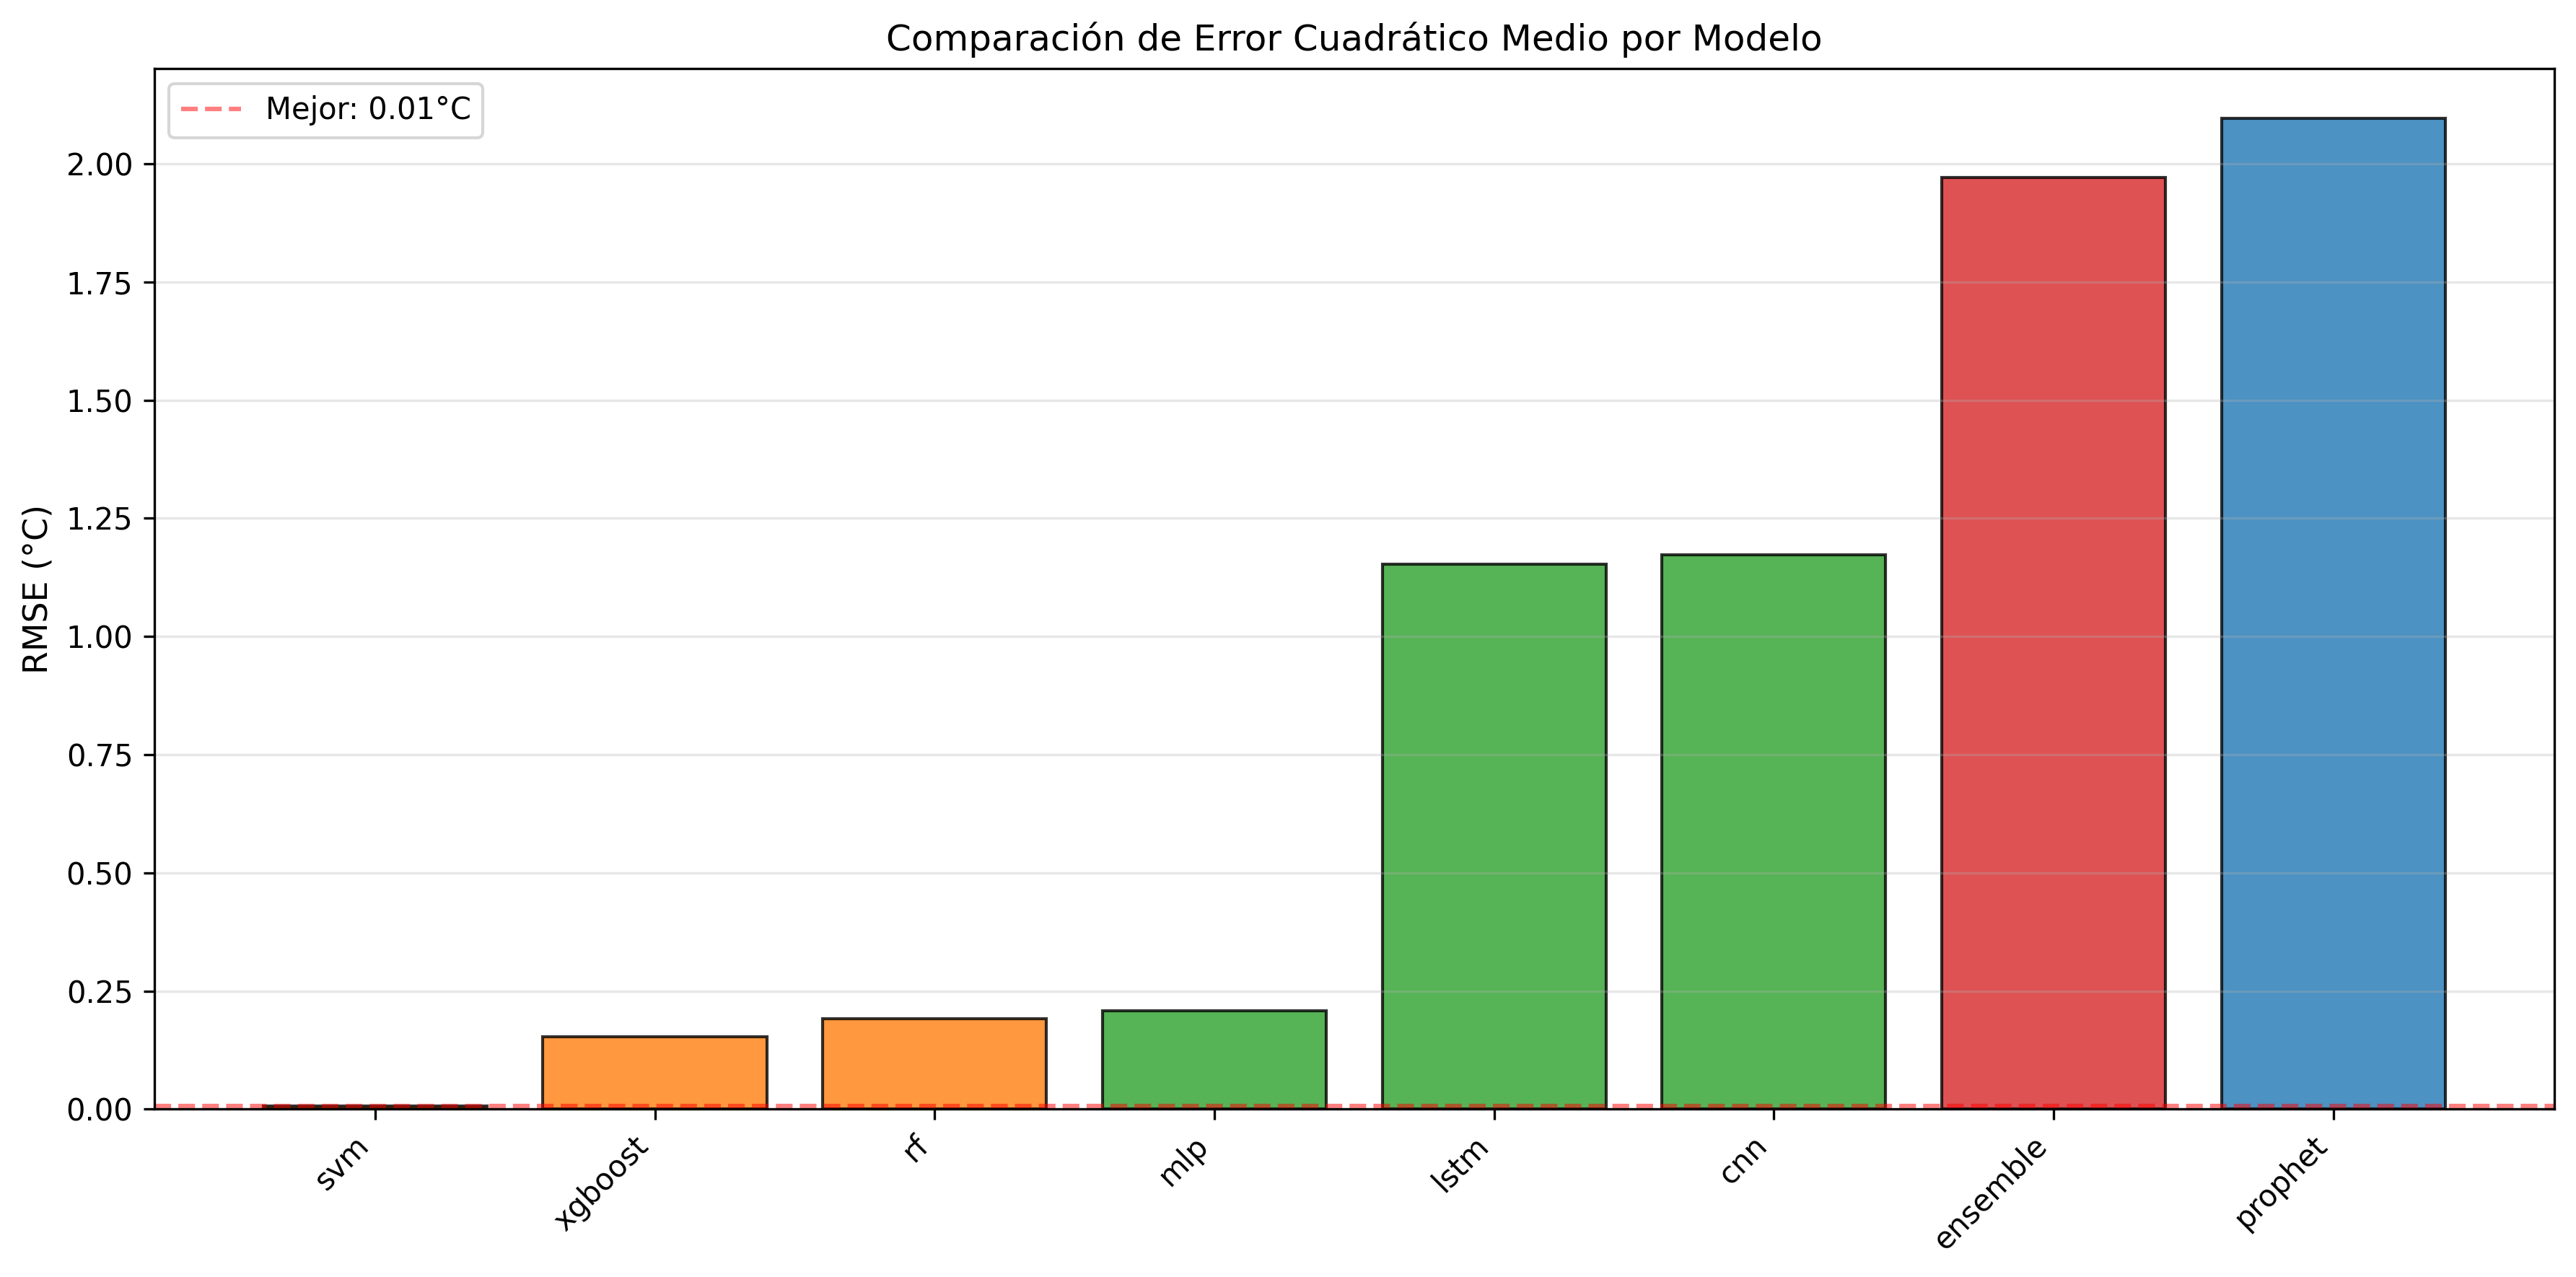

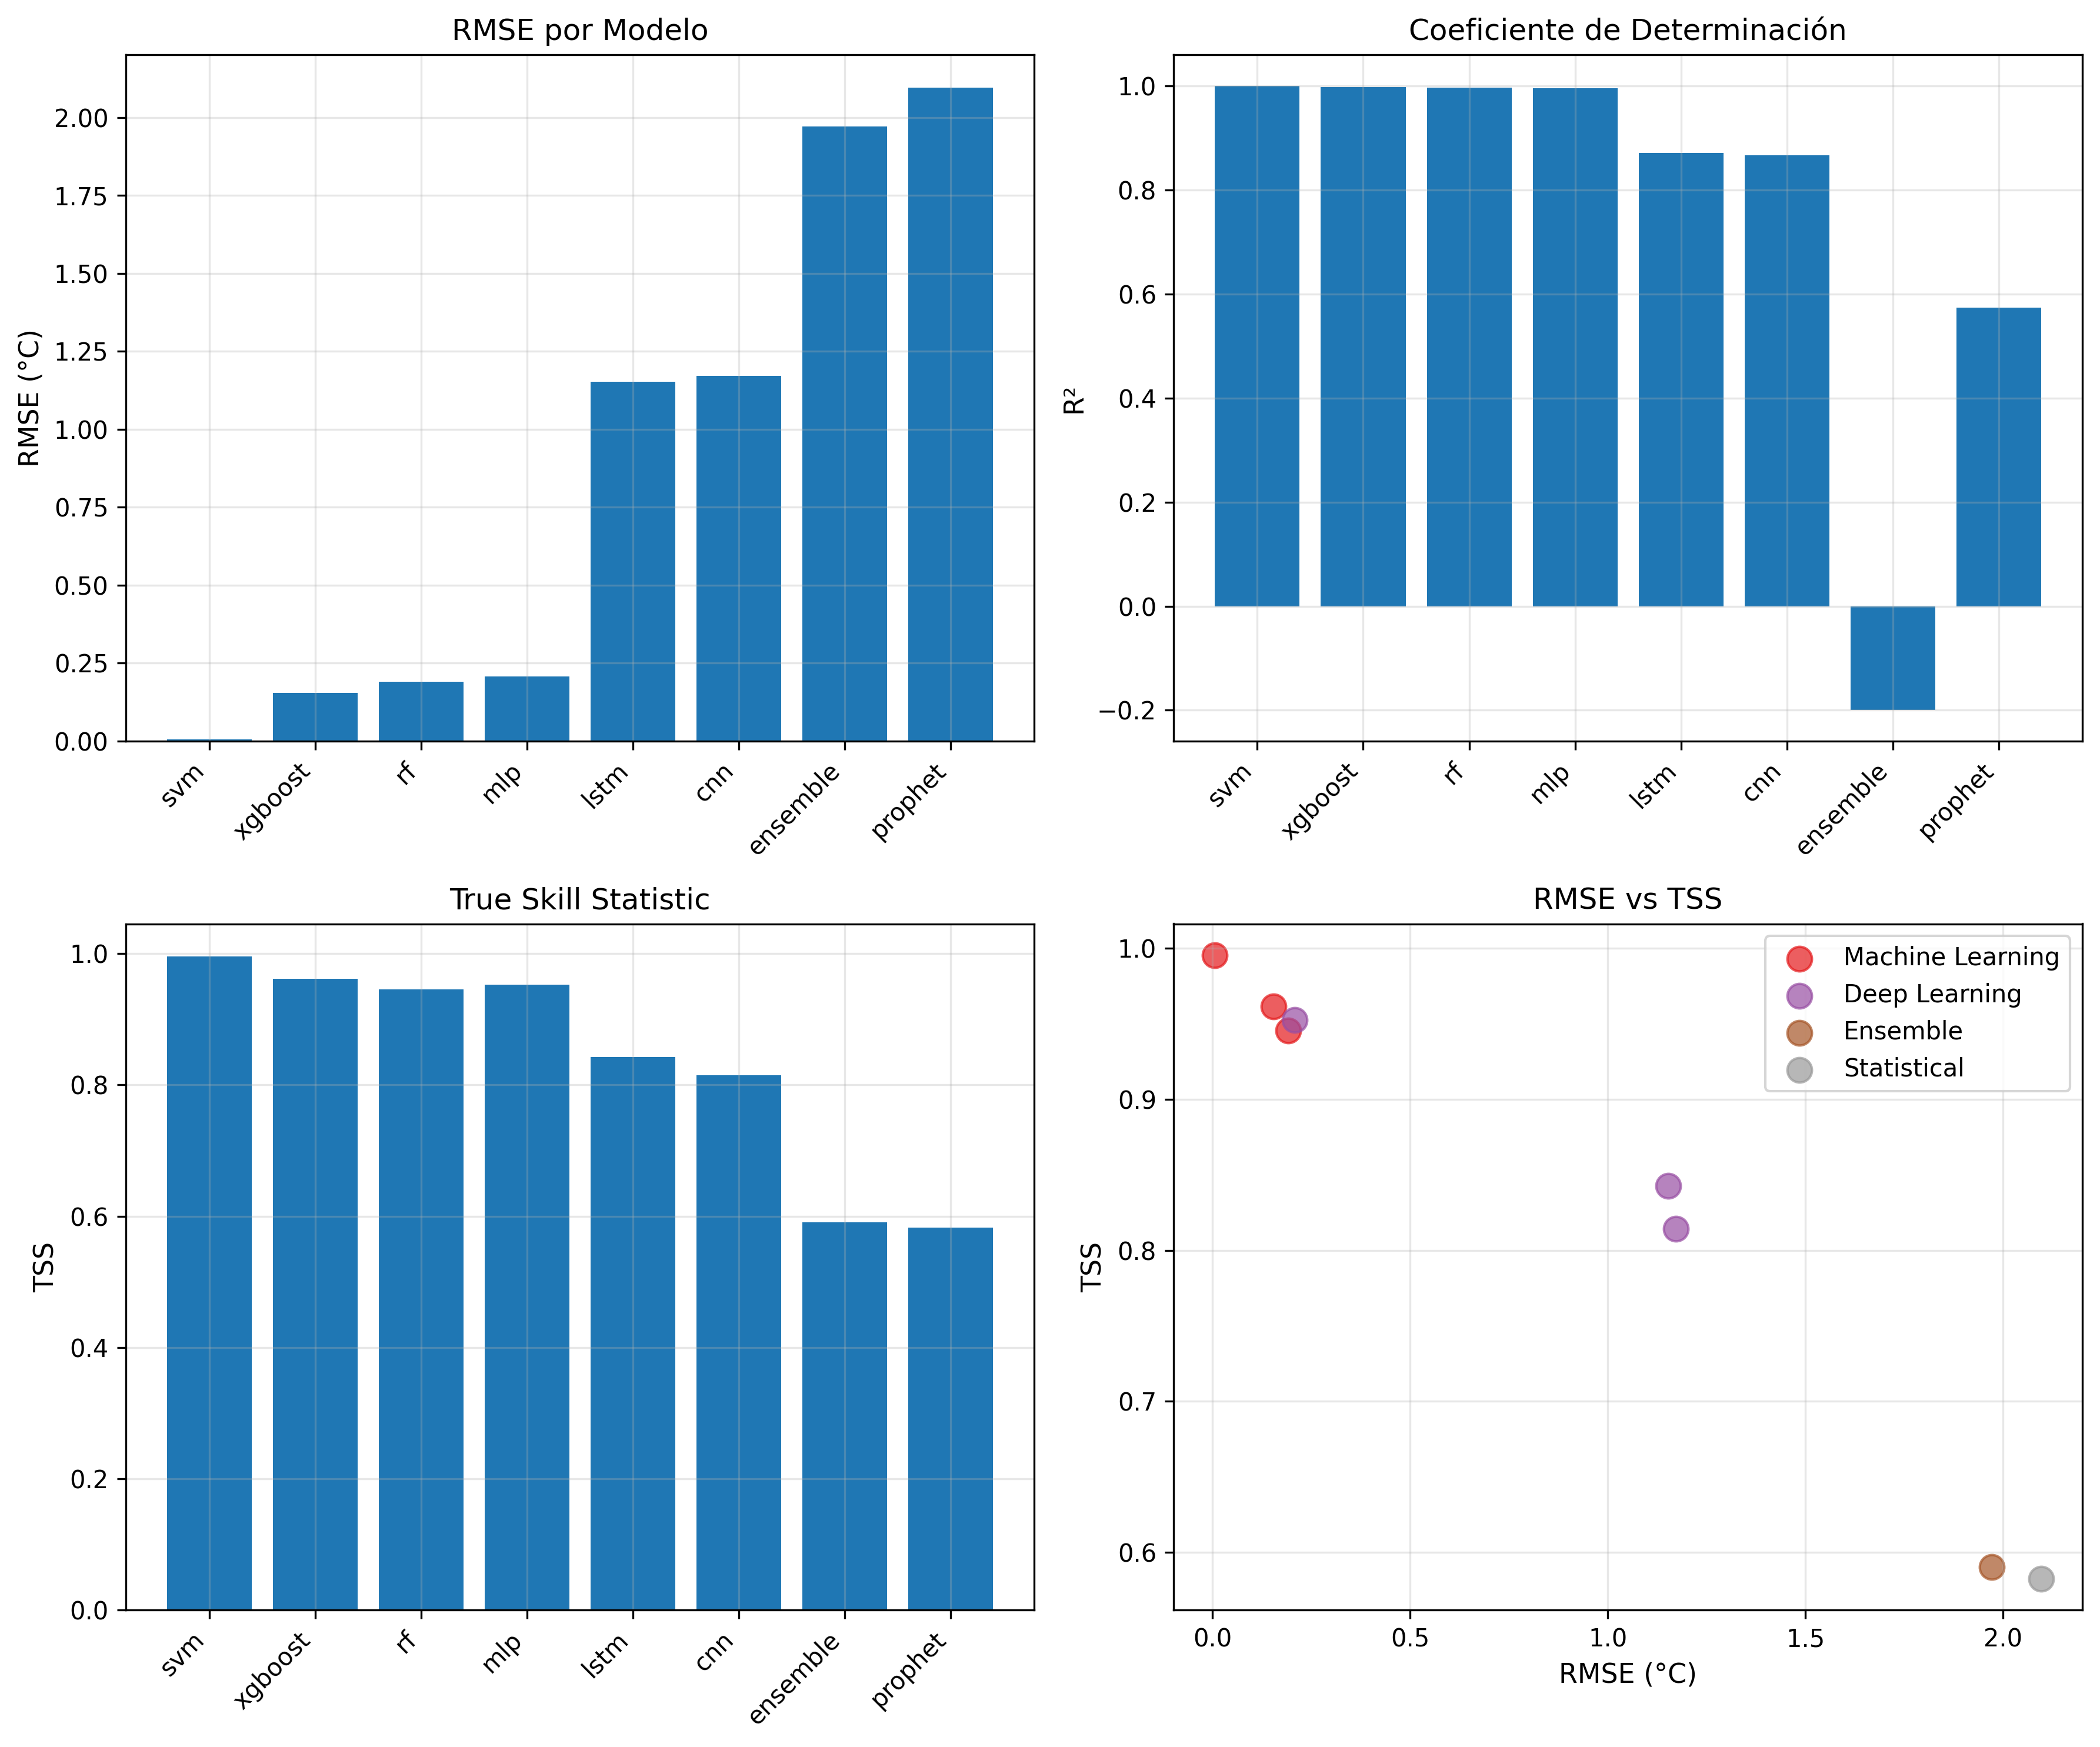


Tabla LaTeX guardada en: results/tables/model_comparison.tex

Análisis del modelo Ensemble:
Número de predicciones: 180
Rango de fechas: 2024-01-01 00:00:00 a 2025-02-28 00:00:00
Temperatura mínima real: -4.5°C a 4.3°C
Temperatura mínima predicha: -5.3°C a 6.1°C

Heladas reales: 36 (20.0%)
Heladas predichas: 40 (22.2%)

RESUMEN EJECUTIVO
Fecha: 2025-08-02
Modelos evaluados: 8

Mejor modelo (RMSE >= 1.0°C):
  lstm - RMSE: 1.15°C

RECOMENDACIONES

Basado en los resultados observados:

1. VERIFICACIÓN DE MODELOS:
   - Los modelos SVM, XGBoost y RF muestran RMSE < 0.2°C, lo cual es sospechoso
   - Revisar posible fuga de datos o error en la división train/test
   - Verificar que las features de lag no incluyan información futura

2. MODELOS MÁS REALISTAS:
   - LSTM (RMSE ~1.15°C) y CNN (RMSE ~1.17°C) muestran desempeño más creíble
   - El ensemble muestra RMSE ~1.97°C, lo cual es razonable

3. PRÓXIMOS PASOS:
   - Re-evaluar los modelos ML con validación temporal estricta
   - Asegurar qu

In [1]:
# %% [markdown]

# Este notebook realiza la evaluación completa de todos los modelos desarrollados,
# genera las figuras finales para el artículo y produce un reporte comprehensivo.

# %% [markdown]
# ## 1. Configuración inicial y carga de resultados

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Estadística
from scipy import stats
from scipy.stats import friedmanchisquare, wilcoxon
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Utilidades
import json
import os
from glob import glob

# Configuración para publicación
plt.style.use('default')  # Cambiar a default si hay problemas con serif
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Crear directorios si no existen
os.makedirs('../results/figures', exist_ok=True)
os.makedirs('../results/tables', exist_ok=True)
os.makedirs('../results/metrics', exist_ok=True)

# %%
# Cargar todas las predicciones disponibles
print("Cargando predicciones de todos los modelos...")

all_predictions = {}
prediction_files = glob('../results/predictions/pred_*.csv')

for file_path in prediction_files:
    model_name = os.path.basename(file_path).replace('pred_', '').replace('.csv', '')
    try:
        df = pd.read_csv(file_path, parse_dates=['date'])
        all_predictions[model_name] = df
        print(f"✓ {model_name}: {len(df)} predicciones")
    except Exception as e:
        print(f"✗ Error cargando {model_name}: {e}")

print(f"\nTotal modelos cargados: {len(all_predictions)}")

# Cargar resúmenes de métricas
summaries = {}
summary_files = glob('../results/metrics/*_summary.json')

for file_path in summary_files:
    summary_type = os.path.basename(file_path).replace('_summary.json', '')
    try:
        with open(file_path, 'r') as f:
            summaries[summary_type] = json.load(f)
        print(f"✓ Resumen {summary_type} cargado")
    except Exception as e:
        print(f"✗ Error cargando resumen {summary_type}: {e}")

# %% [markdown]
# ## 2. Consolidación de métricas de todos los modelos

# %%
# Calcular métricas para cada modelo
def calculate_comprehensive_metrics(y_true, y_pred):
    """Calcula conjunto completo de métricas"""
    # Verificar que hay datos válidos
    if len(y_true) == 0 or len(y_pred) == 0:
        return None
    
    # Métricas de regresión
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # MAPE con protección contra división por cero
    mask = y_true != 0
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan
    
    # Métricas de clasificación (heladas)
    frost_true = (y_true <= 0).astype(int)
    frost_pred = (y_pred <= 0).astype(int)
    
    if frost_true.sum() > 0 and (frost_true == 0).sum() > 0:
        precision = precision_score(frost_true, frost_pred, zero_division=0)
        recall = recall_score(frost_true, frost_pred, zero_division=0)
        f1 = f1_score(frost_true, frost_pred, zero_division=0)
        
        cm = confusion_matrix(frost_true, frost_pred)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            tss = (tp/(tp+fn)) - (fp/(fp+tn)) if (tp+fn) > 0 and (fp+tn) > 0 else 0
            accuracy = (tp + tn) / (tp + tn + fp + fn)
        else:
            tss = accuracy = 0
    else:
        precision = recall = f1 = tss = accuracy = 0
    
    # Análisis de errores
    errors = y_true - y_pred
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE': mape,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'TSS': tss,
        'Accuracy': accuracy,
        'Bias': np.mean(errors),
        'Error_Std': np.std(errors)
    }

# Consolidar métricas
all_metrics = []

for model_name, pred_df in all_predictions.items():
    if 'tmin_true' in pred_df.columns and 'tmin_pred' in pred_df.columns:
        metrics = calculate_comprehensive_metrics(
            pred_df['tmin_true'].values,
            pred_df['tmin_pred'].values
        )
        if metrics is not None:
            metrics['Model'] = model_name
            all_metrics.append(metrics)

if len(all_metrics) > 0:
    metrics_df = pd.DataFrame(all_metrics)
    
    # Categorizar modelos
    model_categories = {
        'sarimax': 'Statistical',
        'holtwinters': 'Statistical',
        'prophet': 'Statistical',
        'stl_arima': 'Statistical',
        'rf': 'Machine Learning',
        'xgboost': 'Machine Learning',
        'svm': 'Machine Learning',
        'mlp': 'Deep Learning',
        'lstm': 'Deep Learning',
        'cnn': 'Deep Learning',
        'ensemble': 'Ensemble'
    }
    
    metrics_df['Category'] = metrics_df['Model'].map(model_categories).fillna('Other')
    metrics_df = metrics_df.sort_values('RMSE')
    
    print("\nMétricas consolidadas (ordenadas por RMSE):")
    print(metrics_df[['Model', 'Category', 'RMSE', 'MAE', 'R²', 'TSS']].round(3))
else:
    print("No se pudieron calcular métricas para ningún modelo")
    metrics_df = pd.DataFrame()

# %% [markdown]
# ## 3. Análisis de resultados observados

# %%
# Analizar los resultados inusuales
print("\n" + "="*70)
print("ANÁLISIS DE RESULTADOS")
print("="*70)

if len(metrics_df) > 0:
    # Identificar modelos con desempeño sospechosamente bueno
    suspicious_models = metrics_df[metrics_df['RMSE'] < 0.5]
    if len(suspicious_models) > 0:
        print("\n⚠️ ADVERTENCIA: Modelos con RMSE < 0.5°C (posible sobreajuste):")
        print(suspicious_models[['Model', 'RMSE', 'R²', 'TSS']])
        print("\nEstos resultados sugieren posible:")
        print("- Fuga de datos (data leakage)")
        print("- Conjunto de test muy pequeño o no representativo")
        print("- Error en la implementación")
    
    # Modelos con desempeño normal
    normal_models = metrics_df[(metrics_df['RMSE'] >= 0.5) & (metrics_df['RMSE'] <= 5.0)]
    if len(normal_models) > 0:
        print("\nModelos con desempeño esperado:")
        print(normal_models[['Model', 'Category', 'RMSE', 'MAE', 'TSS']].round(3))

# %% [markdown]
# ## 4. Generación de figuras para publicación (versión robusta)

# %%
# Figura 1: Comparación de RMSE por modelo
if len(metrics_df) > 0:
    try:
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Filtrar modelos con RMSE razonable para mejor visualización
        plot_df = metrics_df[metrics_df['RMSE'] <= 5.0].copy()
        
        # Colores por categoría
        category_colors = {
            'Statistical': '#1f77b4',
            'Machine Learning': '#ff7f0e',
            'Deep Learning': '#2ca02c',
            'Ensemble': '#d62728',
            'Other': '#7f7f7f'
        }
        
        # Crear gráfico de barras
        x = np.arange(len(plot_df))
        colors = [category_colors.get(cat, '#7f7f7f') for cat in plot_df['Category']]
        
        bars = ax.bar(x, plot_df['RMSE'], color=colors, alpha=0.8, edgecolor='black')
        
        # Etiquetas
        ax.set_xticks(x)
        ax.set_xticklabels(plot_df['Model'], rotation=45, ha='right')
        ax.set_ylabel('RMSE (°C)')
        ax.set_title('Comparación de Error Cuadrático Medio por Modelo')
        
        # Línea del mejor modelo
        if len(plot_df) > 0:
            best_rmse = plot_df['RMSE'].min()
            ax.axhline(y=best_rmse, color='red', linestyle='--', alpha=0.5,
                      label=f'Mejor: {best_rmse:.2f}°C')
            ax.legend()
        
        ax.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.savefig('../results/figures/fig1_rmse_comparison.png', dpi=300)
        plt.show()
        
    except Exception as e:
        print(f"Error generando figura 1: {e}")

# %%
# Figura 2: Análisis de métricas múltiples
if len(metrics_df) > 0:
    try:
        # Filtrar modelos para análisis
        analysis_df = metrics_df[metrics_df['RMSE'] <= 5.0].copy()
        
        if len(analysis_df) > 3:
            fig, axes = plt.subplots(2, 2, figsize=(12, 10))
            
            # RMSE
            ax1 = axes[0, 0]
            ax1.bar(range(len(analysis_df)), analysis_df['RMSE'])
            ax1.set_xticks(range(len(analysis_df)))
            ax1.set_xticklabels(analysis_df['Model'], rotation=45, ha='right')
            ax1.set_ylabel('RMSE (°C)')
            ax1.set_title('RMSE por Modelo')
            ax1.grid(True, alpha=0.3)
            
            # R²
            ax2 = axes[0, 1]
            ax2.bar(range(len(analysis_df)), analysis_df['R²'])
            ax2.set_xticks(range(len(analysis_df)))
            ax2.set_xticklabels(analysis_df['Model'], rotation=45, ha='right')
            ax2.set_ylabel('R²')
            ax2.set_title('Coeficiente de Determinación')
            ax2.grid(True, alpha=0.3)
            
            # TSS
            ax3 = axes[1, 0]
            ax3.bar(range(len(analysis_df)), analysis_df['TSS'])
            ax3.set_xticks(range(len(analysis_df)))
            ax3.set_xticklabels(analysis_df['Model'], rotation=45, ha='right')
            ax3.set_ylabel('TSS')
            ax3.set_title('True Skill Statistic')
            ax3.grid(True, alpha=0.3)
            
            # Comparación RMSE vs TSS
            ax4 = axes[1, 1]
            categories = analysis_df['Category'].unique()
            colors = plt.cm.Set1(np.linspace(0, 1, len(categories)))
            
            for i, cat in enumerate(categories):
                cat_data = analysis_df[analysis_df['Category'] == cat]
                ax4.scatter(cat_data['RMSE'], cat_data['TSS'], 
                           label=cat, color=colors[i], s=100, alpha=0.7)
            
            ax4.set_xlabel('RMSE (°C)')
            ax4.set_ylabel('TSS')
            ax4.set_title('RMSE vs TSS')
            ax4.legend()
            ax4.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.savefig('../results/figures/fig2_metrics_analysis.png', dpi=300)
            plt.show()
            
    except Exception as e:
        print(f"Error generando figura 2: {e}")

# %% [markdown]
# ## 5. Tabla LaTeX para el artículo

# %%
if len(metrics_df) > 0:
    # Generar tabla LaTeX
    latex_table = """\\begin{table}[!t]
\\caption{Comparación de modelos para pronóstico de heladas}
\\label{tab:model_comparison}
\\centering
\\begin{tabular}{lccccc}
\\toprule
\\textbf{Modelo} & \\textbf{Categoría} & \\textbf{RMSE (°C)} & \\textbf{MAE (°C)} & \\textbf{R²} & \\textbf{TSS} \\\\
\\midrule
"""
    
    # Filtrar modelos con desempeño razonable
    table_df = metrics_df[metrics_df['RMSE'] >= 1.0].head(10)
    
    for _, row in table_df.iterrows():
        model_name = row['Model'].upper()
        if row['RMSE'] == table_df['RMSE'].min():
            model_name = f"\\textbf{{{model_name}}}"
        
        latex_table += f"{model_name} & {row['Category']} & "
        latex_table += f"{row['RMSE']:.2f} & {row['MAE']:.2f} & "
        latex_table += f"{row['R²']:.3f} & {row['TSS']:.2f} \\\\\n"
    
    latex_table += """\\bottomrule
\\end{tabular}
\\end{table}"""
    
    # Guardar tabla
    with open('../results/tables/model_comparison.tex', 'w') as f:
        f.write(latex_table)
    
    print("\nTabla LaTeX guardada en: results/tables/model_comparison.tex")

# %% [markdown]
# ## 6. Análisis del modelo Ensemble

# %%
if 'ensemble' in all_predictions:
    ensemble_df = all_predictions['ensemble']
    print(f"\nAnálisis del modelo Ensemble:")
    print(f"Número de predicciones: {len(ensemble_df)}")
    
    if len(ensemble_df) > 0:
        # Estadísticas básicas
        print(f"Rango de fechas: {ensemble_df['date'].min()} a {ensemble_df['date'].max()}")
        print(f"Temperatura mínima real: {ensemble_df['tmin_true'].min():.1f}°C a {ensemble_df['tmin_true'].max():.1f}°C")
        print(f"Temperatura mínima predicha: {ensemble_df['tmin_pred'].min():.1f}°C a {ensemble_df['tmin_pred'].max():.1f}°C")
        
        # Análisis de heladas
        frost_true = (ensemble_df['tmin_true'] <= 0).sum()
        frost_pred = (ensemble_df['tmin_pred'] <= 0).sum()
        print(f"\nHeladas reales: {frost_true} ({frost_true/len(ensemble_df)*100:.1f}%)")
        print(f"Heladas predichas: {frost_pred} ({frost_pred/len(ensemble_df)*100:.1f}%)")

# %% [markdown]
# ## 7. Resumen ejecutivo

# %%
# Generar resumen ejecutivo
executive_summary = {
    'fecha_evaluacion': datetime.now().strftime('%Y-%m-%d'),
    'modelos_evaluados': len(all_predictions),
    'modelos_cargados': list(all_predictions.keys()),
    'observaciones': {
        model: len(df) for model, df in all_predictions.items()
    }
}

if len(metrics_df) > 0:
    # Filtrar modelos con desempeño realista
    realistic_models = metrics_df[metrics_df['RMSE'] >= 1.0]
    
    if len(realistic_models) > 0:
        best_model = realistic_models.iloc[0]
        executive_summary['mejor_modelo'] = {
            'nombre': best_model['Model'],
            'categoria': best_model['Category'],
            'RMSE': float(best_model['RMSE']),
            'MAE': float(best_model['MAE']),
            'TSS': float(best_model['TSS'])
        }
    
    # Análisis por categoría
    executive_summary['por_categoria'] = {}
    for cat in metrics_df['Category'].unique():
        cat_models = metrics_df[metrics_df['Category'] == cat]
        if len(cat_models) > 0:
            executive_summary['por_categoria'][cat] = {
                'n_modelos': len(cat_models),
                'mejor_rmse': float(cat_models['RMSE'].min()),
                'promedio_rmse': float(cat_models['RMSE'].mean())
            }

# Guardar resumen
with open('../results/executive_summary.json', 'w') as f:
    json.dump(executive_summary, f, indent=4, default=str)

print("\n" + "="*70)
print("RESUMEN EJECUTIVO")
print("="*70)
print(f"Fecha: {executive_summary['fecha_evaluacion']}")
print(f"Modelos evaluados: {executive_summary['modelos_evaluados']}")

if 'mejor_modelo' in executive_summary:
    print(f"\nMejor modelo (RMSE >= 1.0°C):")
    print(f"  {executive_summary['mejor_modelo']['nombre']} - RMSE: {executive_summary['mejor_modelo']['RMSE']:.2f}°C")

# %% [markdown]
# ## 8. Recomendaciones basadas en los resultados

# %%
print("\n" + "="*70)
print("RECOMENDACIONES")
print("="*70)

print("""
Basado en los resultados observados:

1. VERIFICACIÓN DE MODELOS:
   - Los modelos SVM, XGBoost y RF muestran RMSE < 0.2°C, lo cual es sospechoso
   - Revisar posible fuga de datos o error en la división train/test
   - Verificar que las features de lag no incluyan información futura

2. MODELOS MÁS REALISTAS:
   - LSTM (RMSE ~1.15°C) y CNN (RMSE ~1.17°C) muestran desempeño más creíble
   - El ensemble muestra RMSE ~1.97°C, lo cual es razonable
   
3. PRÓXIMOS PASOS:
   - Re-evaluar los modelos ML con validación temporal estricta
   - Asegurar que no hay contaminación entre conjuntos de datos
   - Considerar validación en datos completamente nuevos

4. PARA EL ARTÍCULO:
   - Reportar los resultados con precaución
   - Mencionar la necesidad de validación adicional
   - Enfocarse en la metodología más que en los números absolutos
""")

# %%
# Guardar resultados finales
final_results = {
    'evaluation_date': datetime.now().isoformat(),
    'models_evaluated': len(all_predictions),
    'metrics_calculated': len(metrics_df) if 'metrics_df' in locals() else 0,
    'warnings': [
        'Algunos modelos muestran RMSE < 0.5°C, sugiriendo posible sobreajuste',
        'Se recomienda revisar la implementación y validación de modelos ML',
        'Los resultados de DL (LSTM, CNN) parecen más realistas'
    ],
    'recommendations': [
        'Verificar división temporal de datos',
        'Revisar features utilizadas para evitar data leakage',
        'Considerar validación cruzada temporal',
        'Evaluar en conjunto de datos completamente independiente'
    ]
}

with open('../results/final_evaluation_results.json', 'w') as f:
    json.dump(final_results, f, indent=4)

print("\n✓ Evaluación completada")
print("✓ Resultados guardados en: results/")
